https://github.com/brian-team/brian2modelfitting/issues/45

In [1]:
import matplotlib.pyplot as plt

from brian2 import *
import sbi.utils
import sbi.analysis
import sbi.inference
import torch
from torch import nn

In [2]:
defaultclock.dt = 0.1 * ms

In [3]:
def simulate(params, I=1*nA, t_on=50*ms, t_total=350*ms):
    """
    Simulates the HH-model with Brian2 for parameter sets in params and the
    given input current (injection of I between t_on and t_total-t_on).
    Returns a dictionary {'t': time steps, 'v': voltage,
                          'I_inj': current, 'spike_count': spike count}.
    """
    assert t_total > 2*t_on
    t_off = t_total - t_on
    
    params = np.atleast_2d(params)
    # fixed parameters
    gleak = 10*nS
    Eleak = -70*mV
    VT = -60.0*mV
    C = 200*pF
    ENa = 53*mV
    EK = -107*mV

    # The conductance-based model
    eqs = '''
         dVm/dt = -(gNa*m**3*h*(Vm - ENa) + gK*n**4*(Vm - EK) + gleak*(Vm - Eleak) - I_inj) / C : volt
         I_inj = int(t >= t_on and t < t_off)*I : amp (shared)
         dm/dt = alpham*(1-m) - betam*m : 1
         dn/dt = alphan*(1-n) - betan*n : 1
         dh/dt = alphah*(1-h) - betah*h : 1
         alpham = (-0.32/mV) * (Vm - VT - 13.*mV) / (exp((-(Vm - VT - 13.*mV))/(4.*mV)) - 1)/ms : Hz
         betam = (0.28/mV) * (Vm - VT - 40.*mV) / (exp((Vm - VT - 40.*mV)/(5.*mV)) - 1)/ms : Hz
         alphah = 0.128 * exp(-(Vm - VT - 17.*mV) / (18.*mV))/ms : Hz
         betah = 4/(1 + exp((-(Vm - VT - 40.*mV)) / (5.*mV)))/ms : Hz
         alphan = (-0.032/mV) * (Vm - VT - 15.*mV) / (exp((-(Vm - VT - 15.*mV)) / (5.*mV)) - 1)/ms : Hz
         betan = 0.5*exp(-(Vm - VT - 10.*mV) / (40.*mV))/ms : Hz
         # The parameters to fit
         gNa : siemens (constant)
         gK : siemens (constant)
         '''
    neurons = NeuronGroup(params.shape[0], eqs, threshold='m>0.5', refractory='m>0.5',
                          method='exponential_euler', name='neurons')
    Vm_mon = StateMonitor(neurons, 'Vm', record=True, name='Vm_mon')
    spike_mon = SpikeMonitor(neurons, record=False, name='spike_mon')  #record=False → do not record times
    neurons.gNa_ = params[:, 0]*uS
    neurons.gK = params[:, 1]*uS

    neurons.Vm = 'Eleak'
    neurons.m = '1/(1 + betam/alpham)'         # Would be the solution when dm/dt = 0
    neurons.h = '1/(1 + betah/alphah)'         # Would be the solution when dh/dt = 0
    neurons.n = '1/(1 + betan/alphan)'         # Would be the solution when dn/dt = 0

    run(t_total)
    # For convenient plotting, reconstruct the current
    I_inj = ((Vm_mon.t >= t_on) & (Vm_mon.t < t_off))*I
    return dict(v=Vm_mon.Vm,
                t=Vm_mon.t,
                I_inj=I_inj,
                spike_count=spike_mon.count)

In [4]:
def simulation_wrapper(params):
    obs = simulate(params)
    Vm = obs['v'] / mV
    return Vm

In [5]:
prior_min = [.5, 1e-4]
prior_max = [80., 15.]
prior = sbi.utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min),
                                        high=torch.as_tensor(prior_max))

In [6]:
theta = prior.sample((10000, ))
x = torch.tensor(simulation_wrapper(theta), dtype=torch.float32)

In [7]:
class SinLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(SinLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(out_features-1))
    
    def forward(self, x):
        linear = torch.matmul(x, self.w0) + self.b0
        periodic = torch.sin(torch.matmul(x, self.w) + self.b)
        return torch.cat([linear, periodic], axis=1)
    
    def extra_repr(self):
        return (
            f'in_features={self.in_features}, '
            f'out_features={self.out_features}')
    

class Time2Vec(nn.Module):
    def __init__(self):
        super(Time2Vec, self).__init__()
        self.p1 = SinLayer(in_features, hidden_features)
        self.p2 = SinLayer(hidden_features, hidden_features)
        self.l = nn.Linear(hidden_features, embeddings_size)
    
    def forward(self, x):
        x = self.p1(x)
        x = self.p2(x)
        x = self.l(x)
        return x

    
in_features = x.shape[1]
hidden_features = 100
embeddings_size = 10
embedding_net = Time2Vec()
print(embedding_net)

Time2Vec(
  (p1): SinLayer(in_features=3500, out_features=100)
  (p2): SinLayer(in_features=100, out_features=100)
  (l): Linear(in_features=100, out_features=10, bias=True)
)


In [8]:
density_esimator = sbi.utils.posterior_nn(model='maf', embedding_net=embedding_net)

In [9]:
inference = sbi.inference.SNPE(prior, density_estimator=density_esimator)

In [10]:
_ = inference.append_simulations(theta, x).train()

Neural network successfully converged after 159 epochs.


In [11]:
posterior = inference.build_posterior()

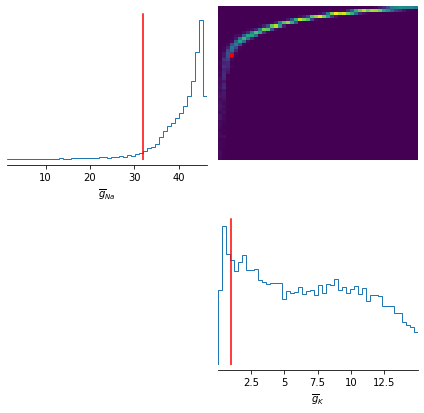

In [12]:
true_params = np.array([[32., 1.]])
x_o = torch.tensor(simulation_wrapper(true_params), dtype=torch.float32)

samples = posterior.sample((10000,), x=x_o, show_progress_bars=False)
labels_params = [r'$\overline{g}_{Na}$', r'$\overline{g}_{K}$']
sbi.analysis.pairplot(samples,
                      figsize=(6, 6),
                      points=true_params,
                      labels=labels_params,
                      points_offdiag={'markersize': 6},
                      points_colors=['r'])
plt.tight_layout()